Step 0: Import

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD

Step 1: Concatenation

In [11]:
# Build NLP vectors by concatenating only the text/object columns (ignore numeric columns)
merge_cols = ['name', 'name_search', 'remarks', 'synonyms', 'brands', 'brands_search', 'bron', 'categories']

def col_to_text(col):
    # Prefer preprocessed object columns if available, otherwise fallback to raw df values
    if 'df_object_processed' in globals() and col in df_object_processed.columns:
        return df_object_processed[col].fillna('').astype(str)
    return df[col].fillna('').astype(str).apply(lambda x: f"{col} {x.strip()}" if x.strip() else "")

# Concatenate the selected columns into a single text field per row (skip empty pieces)
parts_df = pd.concat([col_to_text(c) for c in merge_cols], axis=1)
parts_df.columns = merge_cols

# Ensure we have an ID column copy and create nlp_vector
df_id = df[[id_col]].copy()
df_id['nlp_vector'] = parts_df.apply(lambda row: ' '.join([str(v) for v in row if v and str(v).strip()]), axis=1)

# Rename id column to product_id and save
df_id.rename(columns={id_col: 'product_id'}, inplace=True)
df_id.to_csv('food_nlp_vectors_with_id_only_text.csv', index=False)


Step 2: Create vector

In [ ]:
product_vector_data = pd.read_csv('food_nlp_vectors_with_id.csv')

# settings that you use for count vectorizer will go here 
tfidf_vectorizer = TfidfVectorizer(use_idf=True) 

# just send in all your docs here 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(product_vector_data['nlp_vector'])

# get the first vector out (for the first document) 
first_vector_tfidfvectorizer = tfidf_vectorizer_vectors[0] 

In [13]:
product_vector_data_only_text = pd.read_csv('food_nlp_vectors_with_id_only_text.csv')

n_before = len(product_vector_data_only_text)
product_vector_data_only_text.dropna(subset=['nlp_vector'], inplace=True)
product_vector_data_only_text.reset_index(drop=True, inplace=True)
print(f"Dropped {n_before - len(product_vector_data_only_text)} rows with NaN nlp_vector. Remaining: {len(product_vector_data_only_text)}")

# settings that you use for count vectorizer will go here 
tfidf_vectorizer_only_text = TfidfVectorizer(use_idf=True) 

# just send in all your docs here 
tfidf_vectorizer_vectors_only_text = tfidf_vectorizer_only_text.fit_transform(product_vector_data_only_text['nlp_vector'])

# get the first vector out (for the first document) 
first_vector_tfidfvectorizer_only_text = tfidf_vectorizer_vectors_only_text[0] 

Dropped 3 rows with NaN nlp_vector. Remaining: 17912


Setp 3: DBSCAN

In [5]:
dbscan = DBSCAN(eps=0.3, min_samples=3, metric='cosine') # Using cosine distance for better text vector comparison

# Fit DBSCAN on the TF-IDF matrix (one row per product) and save labels to product_text
labels = dbscan.fit_predict(tfidf_vectorizer_vectors)
product_vector_data['cluster_id'] = labels

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 172
Estimated number of noise points: 3810


In [22]:
dbscan_only_text = DBSCAN(eps=0.3, min_samples=3, metric='cosine') # Using cosine distance for better text vector comparison

# Fit DBSCAN on the TF-IDF matrix (one row per product) and save labels to product_text
labels_only_text = dbscan_only_text.fit_predict(tfidf_vectorizer_vectors_only_text)
product_vector_data_only_text['cluster_id'] = labels_only_text

n_clusters_only_text = len(set(labels_only_text)) - (1 if -1 in labels_only_text else 0)
nonly_noise_only_text = list(labels_only_text).count(-1)

print("Estimated number of clusters: %d" % n_clusters_only_text)
print("Estimated number of noise points: %d" % nonly_noise_only_text)

Estimated number of clusters: 925
Estimated number of noise points: 11497


Step 4: Show result

In [6]:
def plot_dbscan_svd(tfidf_matrix,
                    labels=labels,
                    dbscan_model=dbscan,
                    n_components=2,
                    figsize=(10, 6),
                    marker_core_size=50,
                    marker_border_size=8,
                    show_legend=False,
                    title=None):
    """
    Reduce TF-IDF matrix to 2D with TruncatedSVD and plot DBSCAN clusters.
    Returns: coords_2d, svd, fig, ax
    Defaults use variables already defined in the notebook.
    """
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    coords_2d = svd.fit_transform(tfidf_matrix)

    unique_labels = sorted(set(labels))
    core_samples_mask = np.zeros_like(labels, dtype=bool)
    core_idx = getattr(dbscan_model, "core_sample_indices_", None)
    if core_idx is not None:
        core_samples_mask[core_idx] = True

    fig, ax = plt.subplots(figsize=figsize)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = (0, 0, 0, 1)  # black for noise

        class_member_mask = labels == k
        mask_core = class_member_mask & core_samples_mask
        mask_border = class_member_mask & ~core_samples_mask

        xy_core = coords_2d[mask_core]
        if xy_core.size:
            ax.scatter(xy_core[:, 0], xy_core[:, 1],
                       facecolor=tuple(col), edgecolor="k",
                       s=marker_core_size, marker="o",
                       label=f"cluster {k}" if k != -1 else "noise")

        xy_border = coords_2d[mask_border]
        if xy_border.size:
            ax.scatter(xy_border[:, 0], xy_border[:, 1],
                       facecolor=tuple(col), edgecolor="k",
                       s=marker_border_size, marker="o")

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if title is None:
        title = f"Estimated number of clusters: {n_clusters}"
    ax.set_title(title)

    if show_legend:
        ax.legend(loc="best", markerscale=1, fontsize="small", ncol=2)

    plt.show()
    return coords_2d, svd, fig, ax

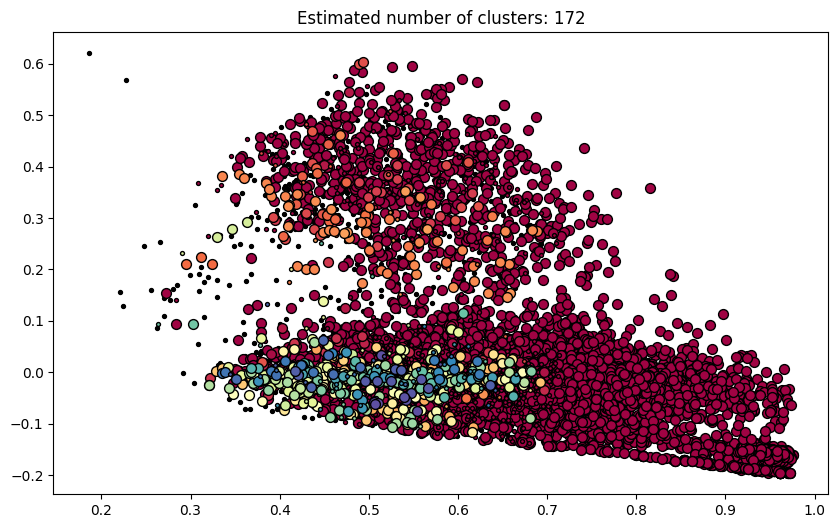

(array([[ 0.6385575 , -0.11854526],
        [ 0.54865427, -0.10201044],
        [ 0.57481537, -0.10653687],
        ...,
        [ 0.68309603, -0.05509411],
        [ 0.80770855, -0.16301646],
        [ 0.64096082, -0.05382857]]),
 TruncatedSVD(random_state=42),
 <Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Estimated number of clusters: 172'}>)

In [18]:
plot_dbscan_svd(tfidf_vectorizer_vectors,
                labels,
                dbscan,
                2,
                (10, 6),
                50,
                8,
                False,
                None
)

In [ ]:
product_vector_data

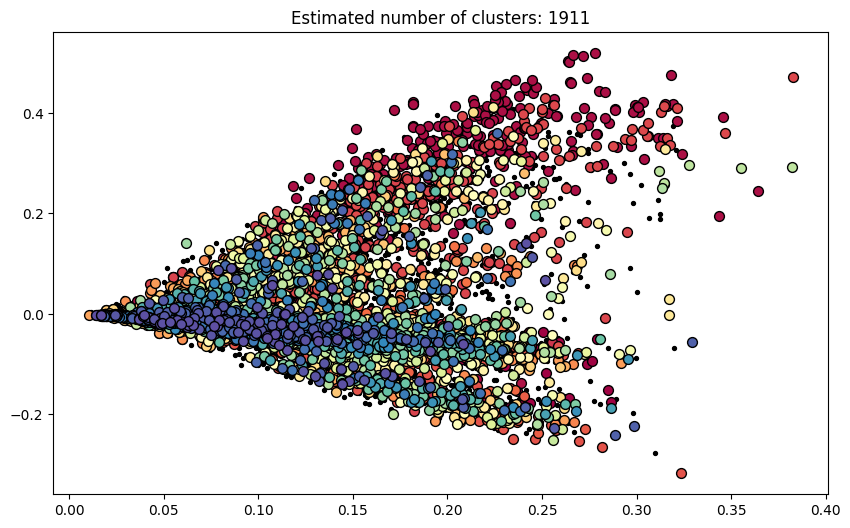

(array([[ 0.05242292, -0.00356375],
        [ 0.04169979, -0.00290835],
        [ 0.04436079, -0.00319265],
        ...,
        [ 0.04431376, -0.01421687],
        [ 0.02113408, -0.0022201 ],
        [ 0.05507097, -0.02133446]]),
 TruncatedSVD(random_state=42),
 <Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Estimated number of clusters: 1911'}>)

In [19]:
plot_dbscan_svd(tfidf_vectorizer_vectors_only_text,
                labels_only_text,
                dbscan_only_text,
                2,
                (10, 6),
                50,
                8,
                False,
                None
)

In [20]:
product_vector_data_only_text

,product_id,nlp_vector,cluster_id
0,24615,name Dolce Gusto Lungo name_search dolce gusto...,0
1,24616,name Dolce Gusto espresso intenso name_search ...,-1
2,24617,name Dolce Gusto grande intenso name_search do...,1
3,24618,name Dolce Gusto cappuccino name_search dolce ...,1
4,24619,name Dolce Gusto cappuccino ice name_search do...,1
...,...,...,...
17907,45480,name Maiswafels Met Pizzasmaak En Kruiden name...,-1
17908,45481,name ProteÃ¯ne meerzadenbrood name_search prot...,-1
17909,45482,name Veggie sea salade name_search veggie sea ...,-1
17910,45483,name Naam niet gevonden name_search naam niet ...,1584
